# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set constants

In [2]:
EXONS_FILENAME = 'exons.txt'
ALPHA_PER_WINDOW_FILENAME = 'task_d.txt'
FASTA_FILENAME = 'cftr.txt'
WL = 100

# Read data

In [3]:
df = pd.read_csv(ALPHA_PER_WINDOW_FILENAME, sep=' ', header=None,
                 names=['col', 'window_start', 'window_end', 'log_prob', 'alpha'])
df.drop('col', axis=1, inplace=True)

In [4]:
exons = list()
with open(EXONS_FILENAME) as f:
    while s := f.readline():
        start, end = map(int, s.split())
        exons.append((start, end))

In [5]:
human_seq = ''
with open(FASTA_FILENAME) as f:
    has_seen_human = False
    while True:
        s = f.readline().strip()
        if has_seen_human or not s:
            break
        if s[0] == '>':
            if s[1:] == 'Human':
                has_seen_human = True
                while (s := f.readline().strip())[0] != '>':
                    human_seq += s.strip()
            else:
                continue
        else:
            continue

In [6]:
df.head()

,window_start,window_end,log_prob,alpha
0,1,100,-379.050,1.0
1,101,200,-425.570,1.2
2,201,300,-305.689,1.1
3,301,400,-279.439,2.0
4,401,500,-249.284,1.6


# Calculate windows overlaping with exons

We implement the calculation of exons using:
- `check_idx_in_exon`, that checks if base `idx` is in $\left[l,r\right]$ closed interval that corresponds to some exon
- `exon_windows_set`, that for every character in `seq` checks if it is a base or gap (also tracks `sequence_idx` of the last found base), if it's a base, calculates a corresponding window in `seq` and checks if this base in some exon by function `check_idx_in_exon`.

In [7]:
def check_idx_in_exon(idx, exons_list):
    for (l, r) in exons_list:
        if l <= idx <= r:
            return True
    return False


def exon_windows_set(exons_list=None, seq=human_seq, window_length=WL):
    if exons_list is None:
        exons_list = exons

    result = set()
    sequence_idx = 0

    for char_idx, char in enumerate(seq):
        if char != '-':
            sequence_idx += 1

            if check_idx_in_exon(sequence_idx, exons_list):
                start = (char_idx + 1) - ((char_idx + 1) % window_length) + 1
                end = start + window_length - 1
                result.add((start, end))
    return result

In [8]:
sets_ = exon_windows_set()

In [9]:
df['intersect_exon'] = df.apply(lambda x: (x['window_start'], x['window_end']) in sets_, axis="columns")

In [10]:
windows_intersect_exons = df[df['intersect_exon'] == True]
windows_no_intersect_exons = df[df['intersect_exon'] == False]

# Graphs

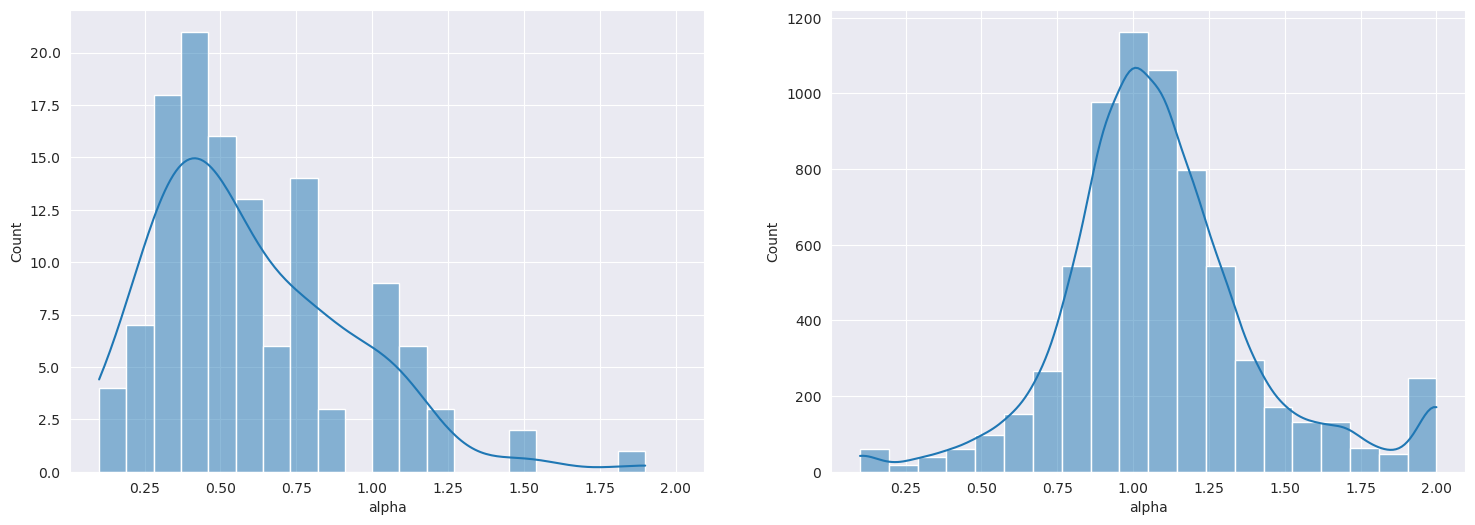

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(18, 6))
sns.histplot(windows_intersect_exons, x='alpha', ax=axes[0], kde=True, bins=20)
sns.histplot(windows_no_intersect_exons, x='alpha', ax=axes[1], kde=True, bins=20)
plt.show()

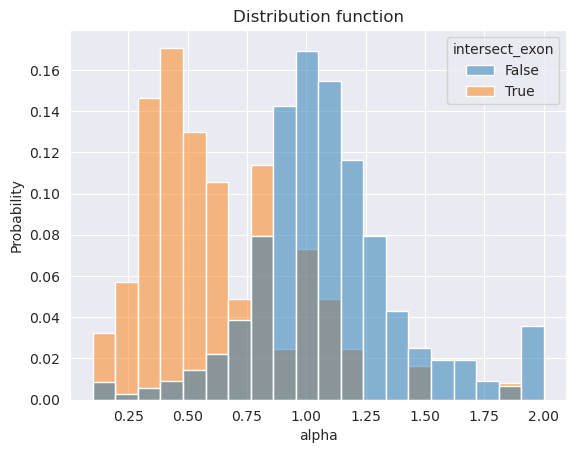

In [12]:
sns.histplot(x='alpha', data=df, hue='intersect_exon', stat="probability", fill=True, common_norm=False, bins=20)
plt.title("Distribution function");

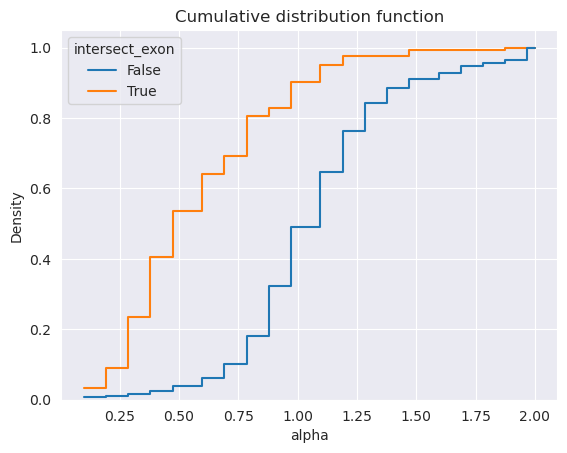

In [13]:
sns.histplot(x='alpha', data=df, hue='intersect_exon', stat="density", element="step", fill=False, cumulative=True,
             common_norm=False)
plt.title("Cumulative distribution function");

# Tests

Inspired by towardsdatascience article: https://towardsdatascience.com/how-to-compare-two-or-more-distributions-9b06ee4d30bf/

In [14]:
from scipy.stats import mannwhitneyu, ttest_ind, kstest

_, p_value = mannwhitneyu(windows_intersect_exons['alpha'], windows_no_intersect_exons['alpha'])
print(f"Mann–Whitney U Test: p-value={p_value:.8f}")

_, p_value = ttest_ind(windows_intersect_exons['alpha'], windows_no_intersect_exons['alpha'])
print(f"t-test: p-value={p_value:.8f}")

_, p_value = kstest(windows_intersect_exons['alpha'], windows_no_intersect_exons['alpha'])
print(f"Kolmogorov-Smirnov Test: p-value={p_value:.8f}")

Mann–Whitney U Test: p-value=0.00000000
t-test: p-value=0.00000000
Kolmogorov-Smirnov Test: p-value=0.00000000
